In [585]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import sklearn
from plotly import graph_objects as go
from plotly import express as px
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

datapath = ""
books = pd.read_csv(datapath + "books.csv")
toRead = pd.read_csv(datapath + "to_read.csv")
tags = pd.read_csv(datapath + "tags.csv")
bookTags = pd.read_csv(datapath + "book_tags.csv")
ratings = pd.read_csv(datapath + "ratings.csv")


In [619]:
from PIL import Image
import requests

def Display_Recommendation(rec, bookId):
    rec = np.array(rec)
    ind = np.argsort(rec[:,2])
    srec = np.array(rec)[ind][::-1]
    srec = srec[:10]
    print("Based on ", books[books["book_id"] ==bookId]["original_title"].values[0], " we recommend : ")
    for i in srec:
        book = books[books["book_id"] == int(i[0])]
        url = book.image_url.values
        if url.size > 0:
            im = Image.open(requests.get(url[0], stream=True).raw)
            display(im)
        print(i[1], " : ", i[2])
        print(book.authors.values[0])
        print("----------------------------------------------------------------")

# Tag based recommendation

In [189]:
booksTagLists = {}
for i in bookTags.values:
    if i[0] in booksTagLists: booksTagLists[i[0]].append([i[1], i[2]])
    else:                     booksTagLists[i[0]] = [[i[1], i[2]]]

In [257]:
from sklearn import preprocessing
def Tags2Vec(tagList):
    ret = np.zeros(len(tags))
    for i in tagList:
        ret[i[0]] = 1
    return ret

def Tags_similarity(tagList1, tagList2):
    return cosine_similarity([Tags2Vec(tagList1)], [Tags2Vec(tagList2)])[0][0]

In [623]:
from sklearn.metrics.pairwise import cosine_similarity
selected = 88077
rec = []
for b in booksTagLists:
    sim = Tags_similarity(booksTagLists[selected], booksTagLists[b])
    if sim > 0.65:
        rec.append([b, books[books["book_id"] == b]["original_title"].values[0], sim])

Based on  Der Zauberberg  we recommend : 


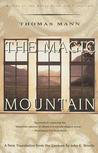

Der Zauberberg  :  1.0000000000000007
Thomas Mann, John E. Woods
----------------------------------------------------------------


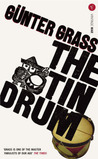

Die Blechtrommel  :  0.7500000000000006
Günter Grass
----------------------------------------------------------------


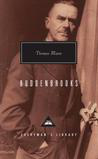

Buddenbrooks: Verfall einer Familie  :  0.7200000000000005
Thomas Mann, John E. Woods, T.J. Reed
----------------------------------------------------------------


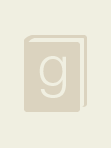

Der Steppenwolf: Erzählung  :  0.7000000000000005
Hermann Hesse, Basil Creighton
----------------------------------------------------------------


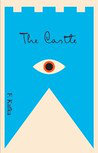

Das Schloß  :  0.6700000000000005
Franz Kafka, Mark Harman, Regaip Minareci, Şerif Yeşilbucak
----------------------------------------------------------------


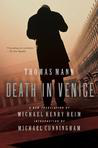

Der Tod in Venedig  :  0.6500000000000005
Thomas Mann, Michael Henry Heim, Michael Cunningham
----------------------------------------------------------------


In [624]:
Display_Recommendation(rec, selected)

# Author based recommendation

In [291]:
AuthorList = {}
for i in books["authors"]:
    authors = i.split(", ")
    for a in authors:
        AuthorList[a] = len(AuthorList)

In [292]:
def Auth2Vec(authors):
    ret = np.zeros(len(AuthorList))
    for i in authors:
        ret[AuthorList[i]] = 1
    return ret

def Authors_similarity(authList1, authList2):
    return cosine_similarity([Auth2Vec(authList1)], [Auth2Vec(authList2)])[0][0]

In [625]:
from sklearn.metrics.pairwise import cosine_similarity
selected = 5954
rec = []
sb = books[books["book_id"] == selected].authors.values[0].split(", ")
for index, b in books.iterrows():
    i = b.authors.split(", ")
    sim = Authors_similarity(sb, i)
    if sim > 0.45:
        rec.append([b.book_id, b.original_title, sim])

Based on  Narziß und Goldmund  we recommend : 


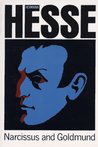

Narziß und Goldmund  :  0.9999999999999998
Hermann Hesse, Ursule Molinaro
----------------------------------------------------------------


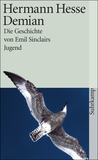

Demian: Die Geschichte einer Jugend  :  0.7071067811865475
Hermann Hesse
----------------------------------------------------------------


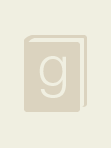

Der Steppenwolf: Erzählung  :  0.4999999999999999
Hermann Hesse, Basil Creighton
----------------------------------------------------------------


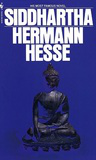

Siddhartha  :  0.4999999999999999
Hermann Hesse, Hilda Rosner
----------------------------------------------------------------


In [626]:
Display_Recommendation(rec, selected)

In [589]:
from sklearn.metrics.pairwise import cosine_similarity
selected = 1
rec = []
sb = ["Thomas Mann"]
for index, b in books.iterrows():
    i = b.authors.split(", ")
    sim = Authors_similarity(sb, i)
    
    if sim > 0.65:
        rec.append([b.book_id, b.original_title, sim])

rec = np.array(rec)
ind=np.argsort(rec[:,1])
rec2 = np.array(rec)[ind][::-1]
for i in rec2:
    print(i[0],"  ", i[1], " : ", i[2])

88077    Der Zauberberg  :  1.0
53064    Der Tod in Venedig  :  0.7071067811865475
343    Das Parfum. Die Geschichte eines Mörders  :  0.7071067811865475
80890    Buddenbrooks: Verfall einer Familie  :  1.0


# Ratings based recommendation

In [376]:
RatingMatrix = {}
for index, r in ratings.iterrows():
    if r.book_id not in RatingMatrix: RatingMatrix[r.book_id] = [[r.user_id, r.rating]]
    else: RatingMatrix[r.book_id].append([r.user_id, r.rating])
    

In [389]:
def Rating2Vec(UserRatings):
    ret = np.zeros(len(ratings.user_id.values))
    for i in UserRatings:
        ret[i[0]] = i[1]
    return ret

def Ratings_similarity(ratings1, ratings2):
    return cosine_similarity([Rating2Vec(ratings1)], [Rating2Vec(ratings2)])[0][0]

# Mixed recommendation

In [627]:
def Recommend_with_book(bookId, n=10):
    rec = []
    st = booksTagLists[bookId]
    wb = [0.8, 0.05, 0.15]
    if bookId in RatingMatrix: sr = RatingMatrix[bookId]
    else : wb = [0.85, 0, 0.15]
    sa = books[books["book_id"] == bookId].authors.values[0].split(", ")
    for index, b in books.iterrows():
        w = wb
        t = booksTagLists[b.book_id]
        a = b.authors.split(", ")
        
        if b.book_id not in RatingMatrix: w = [0.85, 0, 0.15]
        
        simT = Tags_similarity(st, t)
        if w[1] != 0: simR = Ratings_similarity(sr, RatingMatrix[b.book_id])
        else : simR = 0
        simA = Authors_similarity(sa, a)
        
        sim = (w[0] * simT + w[1] * simR + w[2] * simA)
        if sim > 0.5:
            rec.append([b.book_id, b.original_title, sim])
            
    rec = np.array(rec)
    ind=np.argsort(rec[:,2])
    srec = np.array(rec)[ind][::-1]
    return srec[:10]

In [628]:
bookId = 485894
rec = Recommend_with_book(bookId)

Based on  Die Verwandlung  we recommend : 


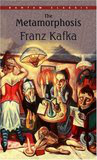

Die Verwandlung  :  1.0000000000000004
Franz Kafka, Stanley Corngold
----------------------------------------------------------------


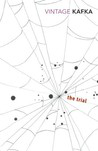

Der Prozeß  :  0.6902372435695799
Franz Kafka, Edwin Muir, Willa Muir, Max Brod
----------------------------------------------------------------


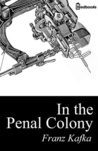

In der Strafkolonie  :  0.6415660171779826
Franz Kafka
----------------------------------------------------------------


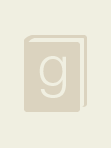

Die Verwandlung und andere Erzählungen  :  0.5882372435695798
Franz Kafka, Jason Baker, Donna Freed
----------------------------------------------------------------


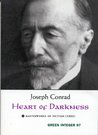

Heart of Darkness  :  0.5695000000000005
Joseph Conrad
----------------------------------------------------------------


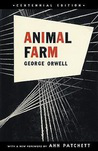

Animal Farm: A Fairy Story  :  0.5440000000000004
George Orwell
----------------------------------------------------------------


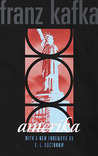

Amerika  :  0.5425000000000003
Franz Kafka, بهرام مقدادی
----------------------------------------------------------------


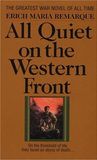

Im Westen nichts Neues  :  0.5355000000000004
Erich Maria Remarque, A.W. Wheen
----------------------------------------------------------------


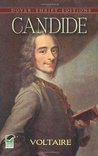

Candide  :  0.5355000000000004
Voltaire
----------------------------------------------------------------


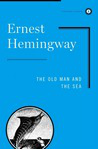

The Old Man and the Sea  :  0.5355000000000004
Ernest Hemingway
----------------------------------------------------------------


In [631]:
Display_Recommendation(rec, bookId)